# COMPREHENSIVE MACHINE LEARNING PIPELINE

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, classification_report, confusion_matrix,
                             f1_score, recall_score, precision_score)

import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

In [31]:
df = pd.read_csv('/kaggle/input/city-day-cleaned/city_day_cleaned (1).csv')
print(f"Dataset shape: {df.shape}")

# Separate features and targets
feature_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 
                'Benzene', 'Toluene', 'Xylene', 'City']
target_regression = 'AQI'
target_classification = 'AQI_Bucket'

print(f"\nFeatures ({len(feature_cols)}): {feature_cols}")
print(f"Regression target: {target_regression}")
print(f"Classification target: {target_classification}")

Dataset shape: (27284, 15)

Features (13): ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'City']
Regression target: AQI
Classification target: AQI_Bucket


In [32]:
# Create a copy for feature engineering
df_fe = df.copy()

# 2.1: Log transformation for skewed features
print("\n Applying log transformation to highly skewed features...")
skewed_features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2']
for feature in skewed_features:
    df_fe[f'{feature}_log'] = np.log1p(df_fe[feature])
    print(f"  Created: {feature}_log")

# 2.2: City encoding (Target Encoding)
print("\n Encoding City feature using Target Encoding...")
city_aqi_mean = df_fe.groupby('City')[target_regression].mean()
df_fe['City_Encoded'] = df_fe['City'].map(city_aqi_mean)
print(f"  Created: City_Encoded (based on mean AQI per city)")

# 2.3: Feature interaction (optional - create a few key interactions)
print("\n Creating feature interactions...")
df_fe['PM_Ratio'] = df_fe['PM2.5'] / (df_fe['PM10'] + 1)  # Ratio of fine to coarse PM
df_fe['NOx_Total'] = df_fe['NO'] + df_fe['NO2']  # Total nitrogen oxides
print("  Created: PM_Ratio (PM2.5/PM10)")
print("  Created: NOx_Total (NO + NO2)")

# Prepare feature sets
# Original features (for tree-based models)
features_original = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
                     'Benzene', 'Toluene', 'Xylene', 'City_Encoded']

# Transformed features (for linear models)
features_transformed = [f'{f}_log' for f in skewed_features] + \
                      ['O3', 'Benzene', 'Toluene', 'Xylene', 'City_Encoded']

# Enhanced features (with interactions)
features_enhanced = features_original + ['PM_Ratio', 'NOx_Total']

print(f"\n Feature sets created:")
print(f"  - Original features: {len(features_original)} features")
print(f"  - Transformed features: {len(features_transformed)} features")
print(f"  - Enhanced features: {len(features_enhanced)} features")


 Applying log transformation to highly skewed features...
  Created: PM2.5_log
  Created: PM10_log
  Created: NO_log
  Created: NO2_log
  Created: NOx_log
  Created: NH3_log
  Created: CO_log
  Created: SO2_log

 Encoding City feature using Target Encoding...
  Created: City_Encoded (based on mean AQI per city)

 Creating feature interactions...
  Created: PM_Ratio (PM2.5/PM10)
  Created: NOx_Total (NO + NO2)

 Feature sets created:
  - Original features: 13 features
  - Transformed features: 13 features
  - Enhanced features: 15 features


In [33]:

# Prepare X and y for regression
X_original = df_fe[features_original]
X_transformed = df_fe[features_transformed]
X_enhanced = df_fe[features_enhanced]
y_regression = df_fe[target_regression]
y_classification = df_fe[target_classification]

# Split data (80-20 split)
test_size = 0.2
random_state = 42

X_train_orig, X_test_orig, y_train_reg, y_test_reg = train_test_split(
    X_original, y_regression, test_size=test_size, random_state=random_state
)

X_train_trans, X_test_trans, _, _ = train_test_split(
    X_transformed, y_regression, test_size=test_size, random_state=random_state
)

X_train_enh, X_test_enh, _, _ = train_test_split(
    X_enhanced, y_regression, test_size=test_size, random_state=random_state
)

_, _, y_train_clf, y_test_clf = train_test_split(
    X_original, y_classification, test_size=test_size, random_state=random_state
)

print(f"Training set size: {len(X_train_orig)} samples ({(1-test_size)*100:.0f}%)")
print(f"Test set size: {len(X_test_orig)} samples ({test_size*100:.0f}%)")

Training set size: 21827 samples (80%)
Test set size: 5457 samples (20%)


In [34]:
scaler = StandardScaler()
X_train_trans_scaled = scaler.fit_transform(X_train_trans)
X_test_trans_scaled = scaler.transform(X_test_trans)

# REGRESSION MODELS (PREDICT AQI)

In [35]:
regression_results = {}


print("\n Baseline: Linear Regression")
print("-" * 60)
lr = LinearRegression()
lr.fit(X_train_trans_scaled, y_train_reg)
y_pred_lr = lr.predict(X_test_trans_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr))
mae_lr = mean_absolute_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)

regression_results['Linear Regression'] = {
    'RMSE': rmse_lr,
    'MAE': mae_lr,
    'R2': r2_lr,
    'predictions': y_pred_lr
}

print(f"  RMSE: {rmse_lr:.2f}")
print(f"  MAE:  {mae_lr:.2f}")
print(f"  R²:   {r2_lr:.4f}")


 Baseline: Linear Regression
------------------------------------------------------------
  RMSE: 67.27
  MAE:  44.91
  R²:   0.7293


In [36]:

print("\n Ridge Regression (L2 Regularization)")
print("-" * 60)
ridge = Ridge(alpha=1.0, random_state=random_state)
ridge.fit(X_train_trans_scaled, y_train_reg)
y_pred_ridge = ridge.predict(X_test_trans_scaled)

rmse_ridge = np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test_reg, y_pred_ridge)
r2_ridge = r2_score(y_test_reg, y_pred_ridge)

regression_results['Ridge Regression'] = {
    'RMSE': rmse_ridge,
    'MAE': mae_ridge,
    'R2': r2_ridge,
    'predictions': y_pred_ridge
}

print(f"  RMSE: {rmse_ridge:.2f}")
print(f"  MAE:  {mae_ridge:.2f}")
print(f"  R²:   {r2_ridge:.4f}")


 Ridge Regression (L2 Regularization)
------------------------------------------------------------
  RMSE: 67.27
  MAE:  44.91
  R²:   0.7293


In [37]:

print("\n Random Forest Regressor")
print("-" * 60)
print("  Training with original features...")
rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=random_state,
    n_jobs=-1
)
rf_reg.fit(X_train_orig, y_train_reg)
y_pred_rf = rf_reg.predict(X_test_orig)

rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf)
r2_rf = r2_score(y_test_reg, y_pred_rf)

regression_results['Random Forest'] = {
    'RMSE': rmse_rf,
    'MAE': mae_rf,
    'R2': r2_rf,
    'predictions': y_pred_rf,
    'model': rf_reg
}

print(f"  RMSE: {rmse_rf:.2f}")
print(f"  MAE:  {mae_rf:.2f}")
print(f"  R²:   {r2_rf:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features_original,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)
print("\n  Top 5 Important Features:")
for idx, row in feature_importance.head().iterrows():
    print(f"    {row['feature']:<15}: {row['importance']:.4f}")


 Random Forest Regressor
------------------------------------------------------------
  Training with original features...
  RMSE: 39.07
  MAE:  19.62
  R²:   0.9086

  Top 5 Important Features:
    PM2.5          : 0.4758
    CO             : 0.3818
    PM10           : 0.0528
    NO             : 0.0390
    O3             : 0.0086


In [38]:

if XGBOOST_AVAILABLE:
    print("\n XGBoost Regressor")
    print("-" * 60)
    print("  Training with enhanced features...")
    xgb_reg = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    xgb_reg.fit(X_train_enh, y_train_reg)
    y_pred_xgb = xgb_reg.predict(X_test_enh)

    rmse_xgb = np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb))
    mae_xgb = mean_absolute_error(y_test_reg, y_pred_xgb)
    r2_xgb = r2_score(y_test_reg, y_pred_xgb)

    regression_results['XGBoost'] = {
        'RMSE': rmse_xgb,
        'MAE': mae_xgb,
        'R2': r2_xgb,
        'predictions': y_pred_xgb,
        'model': xgb_reg
    }

    print(f"  RMSE: {rmse_xgb:.2f}")
    print(f"  MAE:  {mae_xgb:.2f}")
    print(f"  R²:   {r2_xgb:.4f}")



 XGBoost Regressor
------------------------------------------------------------
  Training with enhanced features...
  RMSE: 37.82
  MAE:  19.36
  R²:   0.9144



 Model Performance Comparison (Regression):
            Model      RMSE       MAE       R²
          XGBoost 37.823034 19.357452 0.914405
    Random Forest 39.073978 19.619092 0.908649
 Ridge Regression 67.267544 44.912957 0.729262
Linear Regression 67.267651 44.913439 0.729262

 Best Model: XGBoost
  Lowest RMSE: 37.82
  Highest R²: 0.9144

 Saved: 08_regression_results.png


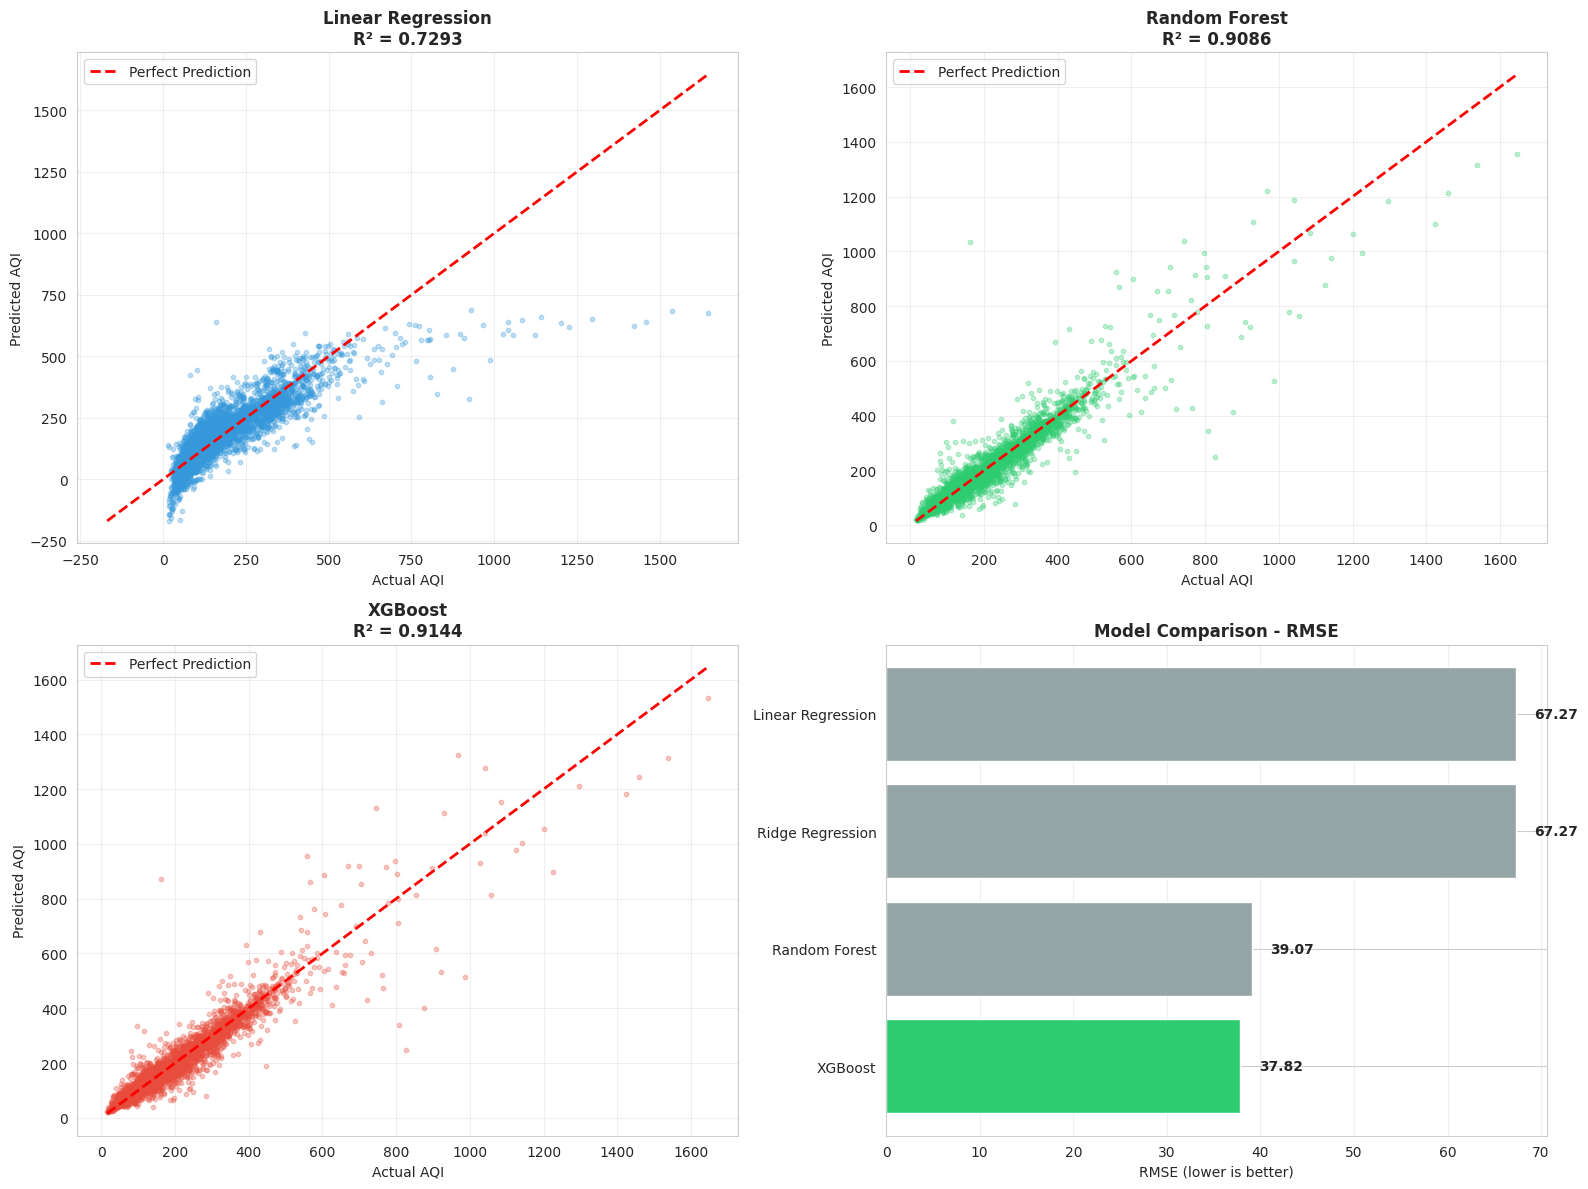

In [39]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(regression_results.keys()),
    'RMSE': [regression_results[m]['RMSE'] for m in regression_results],
    'MAE': [regression_results[m]['MAE'] for m in regression_results],
    'R²': [regression_results[m]['R2'] for m in regression_results]
}).sort_values('RMSE')

print("\n Model Performance Comparison (Regression):")

print(comparison_df.to_string(index=False))

best_model = comparison_df.iloc[0]['Model']
print(f"\n Best Model: {best_model}")
print(f"  Lowest RMSE: {comparison_df.iloc[0]['RMSE']:.2f}")
print(f"  Highest R²: {comparison_df.iloc[0]['R²']:.4f}")

# Visualize regression results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_to_plot = [m for m in ['Linear Regression', 'Random Forest', 'XGBoost'] 
                  if m in regression_results]
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, (model_name, color) in enumerate(zip(models_to_plot, colors)):
    if idx < 4:
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        y_pred = regression_results[model_name]['predictions']
        
        # Scatter plot: Actual vs Predicted
        ax.scatter(y_test_reg, y_pred, alpha=0.3, s=10, color=color)
        
        # Perfect prediction line
        min_val = min(y_test_reg.min(), y_pred.min())
        max_val = max(y_test_reg.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        ax.set_xlabel('Actual AQI')
        ax.set_ylabel('Predicted AQI')
        ax.set_title(f'{model_name}\nR² = {regression_results[model_name]["R2"]:.4f}', 
                     fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3)

# Hide unused subplot if needed
if len(models_to_plot) < 4:
    for i in range(len(models_to_plot), 3):
        row = i // 2
        col = i % 2
        axes[row, col].axis('off')

# Comparison bar chart
ax = axes[1, 1]
x_pos = np.arange(len(comparison_df))
ax.barh(x_pos, comparison_df['RMSE'], color=['#2ecc71' if i == 0 else '#95a5a6' 
                                              for i in range(len(comparison_df))])
ax.set_yticks(x_pos)
ax.set_yticklabels(comparison_df['Model'])
ax.set_xlabel('RMSE (lower is better)')
ax.set_title('Model Comparison - RMSE', fontweight='bold', fontsize=12)
ax.grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['RMSE']):
    ax.text(v + 2, i, f'{v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/08_regression_results.png', dpi=300, bbox_inches='tight')
print("\n Saved: 08_regression_results.png")

### CONVERT PREDICTIONS TO AQI_Bucket

In [40]:
def aqi_to_bucket(aqi):
    """Convert AQI value to bucket"""
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

# Convert best model predictions to buckets
best_pred_aqi = regression_results[best_model]['predictions']
y_pred_buckets_from_reg = np.array([aqi_to_bucket(aqi) for aqi in best_pred_aqi])

print(f"Using {best_model} predictions for bucket conversion...")

# Evaluate bucket classification from regression
bucket_accuracy = accuracy_score(y_test_clf, y_pred_buckets_from_reg)
bucket_f1_macro = f1_score(y_test_clf, y_pred_buckets_from_reg, average='macro')

print(f"\n Classification Performance (from Regression):")
print(f"  Accuracy:     {bucket_accuracy:.4f}")
print(f"  Macro F1:     {bucket_f1_macro:.4f}")

print("\n Classification Report (from Regression):")
print(classification_report(y_test_clf, y_pred_buckets_from_reg))


Using XGBoost predictions for bucket conversion...

 Classification Performance (from Regression):
  Accuracy:     0.8092
  Macro F1:     0.7707

 Classification Report (from Regression):
              precision    recall  f1-score   support

        Good       0.84      0.55      0.67       264
    Moderate       0.82      0.87      0.84      2041
        Poor       0.69      0.71      0.70       582
Satisfactory       0.84      0.83      0.84      1813
      Severe       0.85      0.80      0.83       270
   Very Poor       0.79      0.73      0.76       487

    accuracy                           0.81      5457
   macro avg       0.80      0.75      0.77      5457
weighted avg       0.81      0.81      0.81      5457



###  CLASSIFICATION MODELS (DIRECT AQI_Bucket PREDICTION)

In [41]:
classification_results = {}

# Store regression-based classification for comparison
classification_results[f'{best_model} → Bucket'] = {
    'accuracy': bucket_accuracy,
    'f1_macro': bucket_f1_macro,
    'predictions': y_pred_buckets_from_reg
}

# 8.1: Logistic Regression (Baseline)
print("\n Baseline: Logistic Regression")
print("-" * 60)
logreg = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    random_state=random_state,
    class_weight='balanced'
)
logreg.fit(X_train_trans_scaled, y_train_clf)
y_pred_logreg = logreg.predict(X_test_trans_scaled)

acc_logreg = accuracy_score(y_test_clf, y_pred_logreg)
f1_logreg = f1_score(y_test_clf, y_pred_logreg, average='macro')

classification_results['Logistic Regression'] = {
    'accuracy': acc_logreg,
    'f1_macro': f1_logreg,
    'predictions': y_pred_logreg
}

print(f"  Accuracy:  {acc_logreg:.4f}")
print(f"  Macro F1:  {f1_logreg:.4f}")


 Baseline: Logistic Regression
------------------------------------------------------------
  Accuracy:  0.6738
  Macro F1:  0.6438


In [42]:
# 8.2: Random Forest Classifier
print("\n Random Forest Classifier (RECOMMENDED)")
print("-" * 60)
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=random_state,
    class_weight='balanced',
    n_jobs=-1
)
rf_clf.fit(X_train_orig, y_train_clf)
y_pred_rf_clf = rf_clf.predict(X_test_orig)

acc_rf_clf = accuracy_score(y_test_clf, y_pred_rf_clf)
f1_rf_clf = f1_score(y_test_clf, y_pred_rf_clf, average='macro')

classification_results['Random Forest Classifier'] = {
    'accuracy': acc_rf_clf,
    'f1_macro': f1_rf_clf,
    'predictions': y_pred_rf_clf,
    'model': rf_clf
}

print(f"  Accuracy:  {acc_rf_clf:.4f}")
print(f"  Macro F1:  {f1_rf_clf:.4f}")



 Random Forest Classifier (RECOMMENDED)
------------------------------------------------------------
  Accuracy:  0.8096
  Macro F1:  0.7846


In [43]:
# 8.3: XGBoost Classifier
if XGBOOST_AVAILABLE:
    print("\n XGBoost Classifier (HIGH PERFORMANCE)")
    print("-" * 60)

    # Encode labels for XGBoost
    le = LabelEncoder()
    y_train_clf_encoded = le.fit_transform(y_train_clf)
    y_test_clf_encoded = le.transform(y_test_clf)

    xgb_clf = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    xgb_clf.fit(X_train_enh, y_train_clf_encoded)
    y_pred_xgb_clf_encoded = xgb_clf.predict(X_test_enh)
    y_pred_xgb_clf = le.inverse_transform(y_pred_xgb_clf_encoded)

    acc_xgb_clf = accuracy_score(y_test_clf, y_pred_xgb_clf)
    f1_xgb_clf = f1_score(y_test_clf, y_pred_xgb_clf, average='macro')

    classification_results['XGBoost Classifier'] = {
        'accuracy': acc_xgb_clf,
        'f1_macro': f1_xgb_clf,
        'predictions': y_pred_xgb_clf,
        'model': xgb_clf
    }

    print(f"  Accuracy:  {acc_xgb_clf:.4f}")
    print(f"  Macro F1:  {f1_xgb_clf:.4f}")




 XGBoost Classifier (HIGH PERFORMANCE)
------------------------------------------------------------
  Accuracy:  0.8175
  Macro F1:  0.7872


# STEP 9: CLASSIFICATION MODEL COMPARISON

In [44]:
# Create comparison table
clf_comparison_df = pd.DataFrame({
    'Model': list(classification_results.keys()),
    'Accuracy': [classification_results[m]['accuracy'] for m in classification_results],
    'Macro F1': [classification_results[m]['f1_macro'] for m in classification_results]
}).sort_values('Macro F1', ascending=False)

print("\n Model Performance Comparison (Classification):")

print(clf_comparison_df.to_string(index=False))

best_clf_model = clf_comparison_df.iloc[0]['Model']
print(f"\n Best Classification Model: {best_clf_model}")
print(f"  Highest Macro F1: {clf_comparison_df.iloc[0]['Macro F1']:.4f}")
print(f"  Accuracy: {clf_comparison_df.iloc[0]['Accuracy']:.4f}")

# Detailed report for best model
print(f"\n Detailed Classification Report ({best_clf_model}):")

best_predictions = classification_results[best_clf_model]['predictions']
print(classification_report(y_test_clf, best_predictions))


 Model Performance Comparison (Classification):
                   Model  Accuracy  Macro F1
      XGBoost Classifier  0.817482  0.787239
Random Forest Classifier  0.809602  0.784624
        XGBoost → Bucket  0.809236  0.770726
     Logistic Regression  0.673813  0.643755

 Best Classification Model: XGBoost Classifier
  Highest Macro F1: 0.7872
  Accuracy: 0.8175

 Detailed Classification Report (XGBoost Classifier):
              precision    recall  f1-score   support

        Good       0.80      0.72      0.76       264
    Moderate       0.83      0.86      0.85      2041
        Poor       0.69      0.66      0.68       582
Satisfactory       0.85      0.85      0.85      1813
      Severe       0.86      0.79      0.82       270
   Very Poor       0.78      0.77      0.77       487

    accuracy                           0.82      5457
   macro avg       0.80      0.78      0.79      5457
weighted avg       0.82      0.82      0.82      5457




 Saved: 09_confusion_matrix.png

 Per-Class Performance Metrics:
Good            - Precision: 0.796, Recall: 0.723, F1: 0.758
Moderate        - Precision: 0.829, Recall: 0.862, F1: 0.846
Poor            - Precision: 0.694, Recall: 0.662, F1: 0.677
Satisfactory    - Precision: 0.849, Recall: 0.849, F1: 0.849
Severe          - Precision: 0.855, Recall: 0.789, F1: 0.821
Very Poor       - Precision: 0.780, Recall: 0.766, F1: 0.773

 Saved: 10_classification_comparison.png


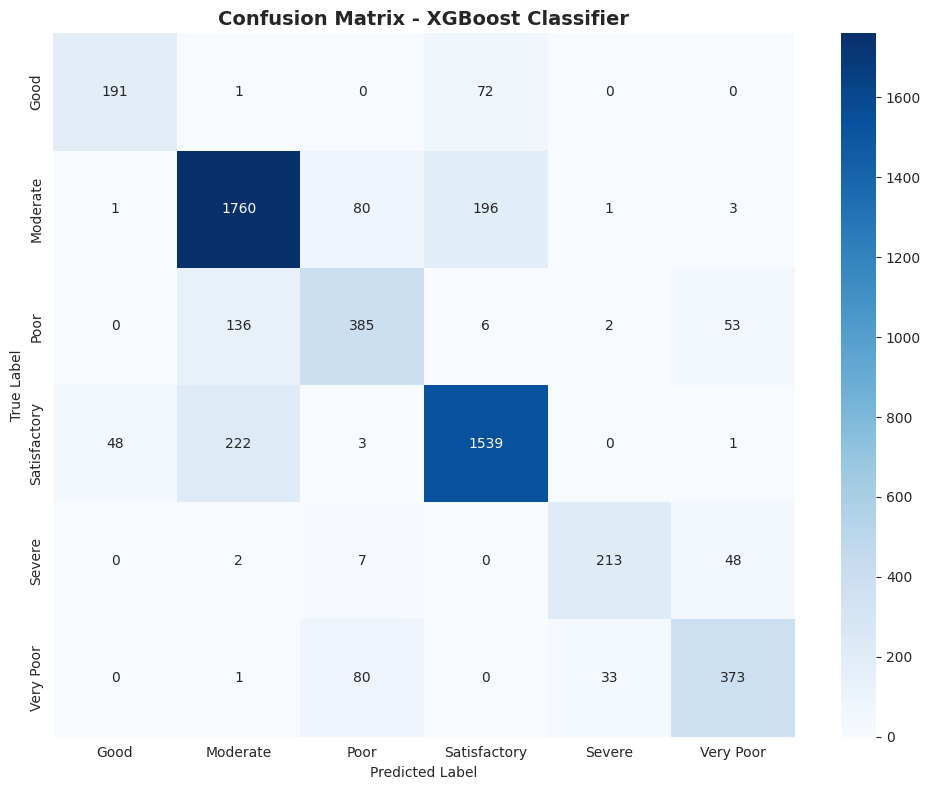

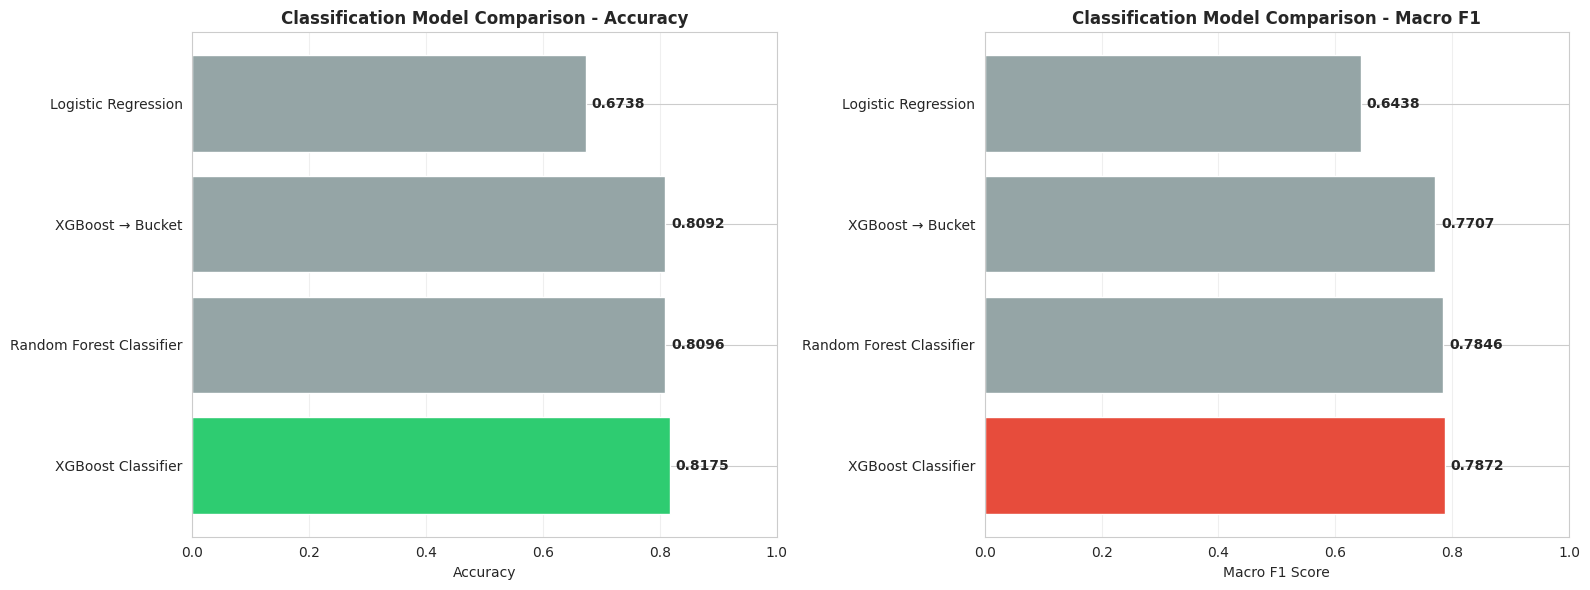

In [45]:
# Confusion matrix
cm = confusion_matrix(y_test_clf, best_predictions)
bucket_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']
labels_in_data = sorted(list(set(y_test_clf)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_in_data,
            yticklabels=labels_in_data)
plt.title(f'Confusion Matrix - {best_clf_model}', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/kaggle/working/09_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n Saved: 09_confusion_matrix.png")

# Per-class metrics
print("\n Per-Class Performance Metrics:")

for label in labels_in_data:
    mask = y_test_clf == label
    if mask.sum() > 0:
        recall = recall_score(y_test_clf == label, best_predictions == label)
        precision = precision_score(y_test_clf == label, best_predictions == label, zero_division=0)
        f1 = f1_score(y_test_clf == label, best_predictions == label, zero_division=0)
        print(f"{label:<15} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
# Model comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
ax1 = axes[0]
x_pos = np.arange(len(clf_comparison_df))
bars = ax1.barh(x_pos, clf_comparison_df['Accuracy'], 
                color=['#2ecc71' if i == 0 else '#95a5a6' for i in range(len(clf_comparison_df))])
ax1.set_yticks(x_pos)
ax1.set_yticklabels(clf_comparison_df['Model'])
ax1.set_xlabel('Accuracy')
ax1.set_title('Classification Model Comparison - Accuracy', fontweight='bold', fontsize=12)
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(clf_comparison_df['Accuracy']):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# Macro F1 comparison
ax2 = axes[1]
bars = ax2.barh(x_pos, clf_comparison_df['Macro F1'],
                color=['#e74c3c' if i == 0 else '#95a5a6' for i in range(len(clf_comparison_df))])
ax2.set_yticks(x_pos)
ax2.set_yticklabels(clf_comparison_df['Model'])
ax2.set_xlabel('Macro F1 Score')
ax2.set_title('Classification Model Comparison - Macro F1', fontweight='bold', fontsize=12)
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(clf_comparison_df['Macro F1']):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/10_classification_comparison.png', dpi=300, bbox_inches='tight')
print("\n Saved: 10_classification_comparison.png")

# STEP 10: FEATURE IMPORTANCE ANALYSIS


 Feature Importance (Random Forest Regressor):
     Feature  Importance
       PM2.5    0.475793
          CO    0.381800
        PM10    0.052750
          NO    0.039007
          O3    0.008590
         NOx    0.007292
         SO2    0.007109
         NH3    0.006637
     Toluene    0.004954
         NO2    0.004867
      Xylene    0.004084
City_Encoded    0.003967
     Benzene    0.003150

 Saved: 11_feature_importance.png


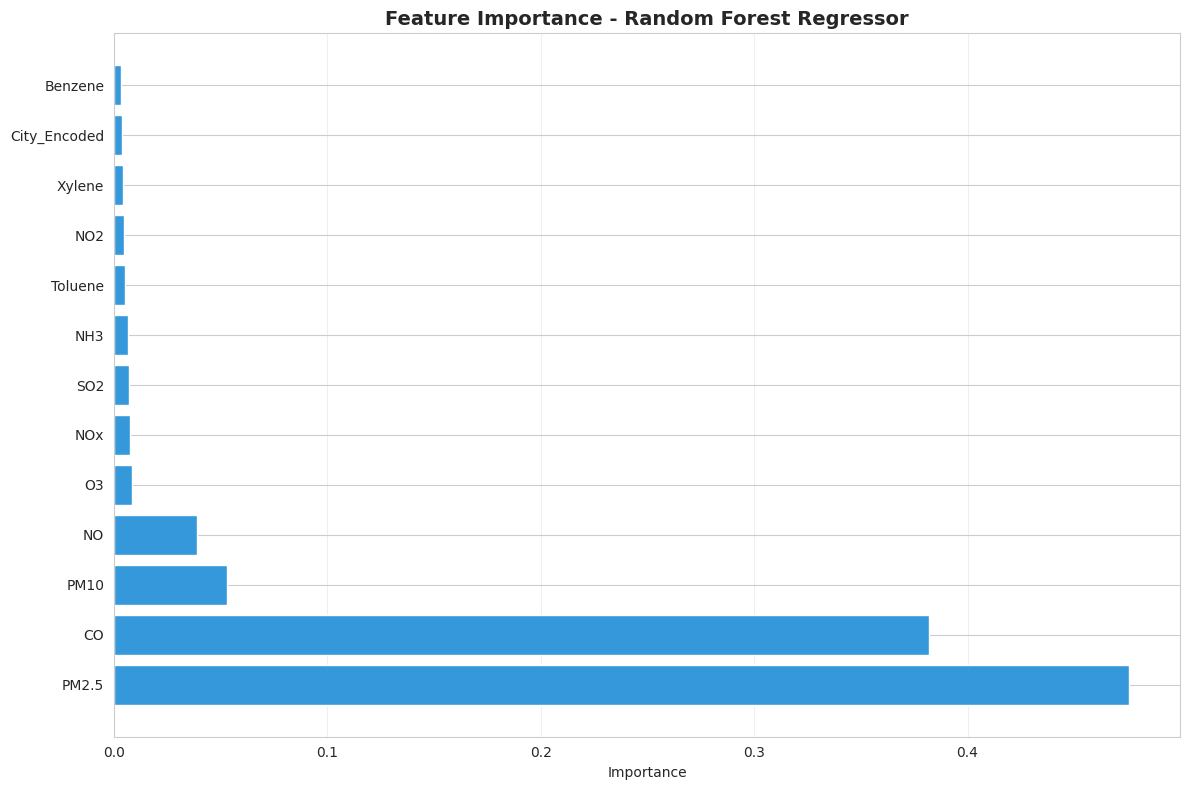

In [46]:
# For Random Forest Regressor
if 'model' in regression_results['Random Forest']:
    print("\n Feature Importance (Random Forest Regressor):")
  
    rf_model = regression_results['Random Forest']['model']
    importance_df = pd.DataFrame({
        'Feature': features_original,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(importance_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(importance_df)), importance_df['Importance'], color='#3498db')
    plt.yticks(range(len(importance_df)), importance_df['Feature'])
    plt.xlabel('Importance')
    plt.title('Feature Importance - Random Forest Regressor', fontweight='bold', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('/kaggle/working/11_feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n Saved: 11_feature_importance.png")

In [47]:
print("\n FOR REGRESSION (AQI Prediction):")
print(f"   Best Model: {best_model}")
print(f"     RMSE: {regression_results[best_model]['RMSE']:.2f}")
print(f"     MAE:  {regression_results[best_model]['MAE']:.2f}")
print(f"     R²:   {regression_results[best_model]['R2']:.4f}")


print("\n FOR CLASSIFICATION (AQI_Bucket Prediction):")
print(f"   Best Model: {best_clf_model}")
print(f"     Accuracy:  {classification_results[best_clf_model]['accuracy']:.4f}")
print(f"     Macro F1:  {classification_results[best_clf_model]['f1_macro']:.4f}")



 FOR REGRESSION (AQI Prediction):
   Best Model: XGBoost
     RMSE: 37.82
     MAE:  19.36
     R²:   0.9144

 FOR CLASSIFICATION (AQI_Bucket Prediction):
   Best Model: XGBoost Classifier
     Accuracy:  0.8175
     Macro F1:  0.7872
